Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

Imports

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

Wrangle Data

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13978 entries, 0 to 3
Data columns (total 7 columns):
ip                13978 non-null object
timestamp         13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(5)
memory usage: 873.6+ KB


In [5]:
df.describe()

,status,size
count,13978.000000,1.397800e+04
mean,200.356703,4.500019e+05
std,10.182001,1.614915e+05
min,200.000000,0.000000e+00
25%,200.000000,5.006370e+05
50%,200.000000,5.101380e+05
75%,200.000000,5.112910e+05
max,499.000000,2.056327e+06


In [6]:
df.columns

Index(['ip', 'timestamp', 'request_method', 'status', 'size', 'destination',
       'request_agent'],
      dtype='object')

In [7]:
df.shape

(13978, 7)

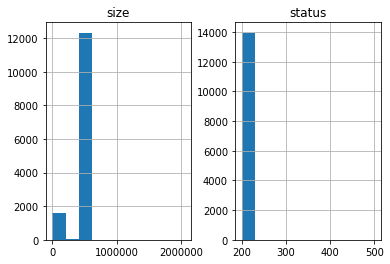

In [8]:
df.hist()
plt.show()

Prepare

In [9]:
df.status.value_counts()

200    13960
499       16
301        2
Name: status, dtype: int64

In [10]:
df[df.status == 301]

,ip,timestamp,request_method,status,size,destination,request_agent
1,95.31.16.121,[17/Apr/2019:19:36:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,1005,NaN,python-requests/2.21.0
2,97.105.15.120,[18/Apr/2019:19:42:41+0000],GET /api/v1/sales?page=79/HTTP/1.1,301,2560,NaN,python-requests/2.21.0


In [11]:
df[df.status == 499]

,ip,timestamp,request_method,status,size,destination,request_agent
1745,97.105.19.58,[16/Apr/2019:19:55:15 +0000],"""GET /api/v1/sales?page=2 HTTP/1.1""",499,0,NaN,"""python-requests/2.20.1"""
1819,97.105.19.58,[16/Apr/2019:19:56:02 +0000],"""GET /api/v1/sales?page=21 HTTP/1.1""",499,0,NaN,"""python-requests/2.20.1"""
4242,97.105.19.58,[16/Apr/2019:20:28:46 +0000],"""GET /api/v1/sales?page=2 HTTP/1.1""",499,0,NaN,"""python-requests/2.21.0"""
4405,97.105.19.58,[16/Apr/2019:20:33:24 +0000],"""GET /api/v1/sales?page=29 HTTP/1.1""",499,0,NaN,"""python-requests/2.21.0"""
4790,97.105.19.58,[16/Apr/2019:20:38:13 +0000],"""GET /api/v1/items HTTP/1.1""",499,0,NaN,"""python-requests/2.21.0"""
4862,97.105.19.58,[16/Apr/2019:20:38:55 +0000],"""GET /api/v1/items HTTP/1.1""",499,0,NaN,"""python-requests/2.21.0"""
4871,97.105.19.58,[16/Apr/2019:20:39:00 +0000],"""GET /api/v1/items HTTP/1.1""",499,0,NaN,"""python-requests/2.21.0"""
5520,97.105.19.58,[16/Apr/2019:20:45:17 +0000],"""GET /api/v1/items HTTP/1.1""",499,0,NaN,"""python-requests/2.21.0"""
5539,97.105.19.58,[16/Apr/2019:20:45:28 +0000],"""GET /api/v1/sales?page=2 HTTP/1.1""",499,0,NaN,"""python-requests/2.21.0"""
6860,97.105.19.58,[16/Apr/2019:21:00:35 +0000],"""GET /api/v1/sales?page=115 HTTP/1.1""",499,0,NaN,"""python-requests/2.20.1"""


In [12]:
# Parse Datetime
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')

In [13]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42+00:00 to 2019-04-19 19:42:41+00:00
Data columns (total 6 columns):
ip                13978 non-null object
request_method    13978 non-null object
status            13978 non-null int64
size              13978 non-null int64
destination       25 non-null object
request_agent     13978 non-null object
dtypes: int64(2), object(4)
memory usage: 764.4+ KB


In [15]:
# Cleanup text
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [16]:
# Add column converting bytes to mb
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [17]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [18]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1items HTTP/1.1                           2
GET /api/v1 HTTP/1.1                                1
GET /api/V1/HiZach! HTTP/1.1                        1
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/I_DIDNT_DO_IT!!!

In [19]:
df.request_agent.value_counts()
# python request library - 2.21.0 version
# major_version.minor_version.patch.hotfix
# majority of requests are from python inside of codeup

python-requests/2.21.0                                                                                                       12005
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

In [20]:
df.size_mb.value_counts(bins=6)
# the negative is a binning anomaly, use domain knowledge to know 

(0.327, 0.654]       12321
(-0.00296, 0.327]     1655
(1.634, 1.961]           1
(0.981, 1.307]           1
(1.307, 1.634]           0
(0.654, 0.981]           0
Name: size_mb, dtype: int64

In [21]:
# majority of requests come in on Tuesday, with some on Wednesday
df.groupby(df.index.dayofweek).agg(['count'])

,ip,request_method,status,size,destination,request_agent,size_mb
,count,count,count,count,count,count,count
timestamp,,,,,,,
1,11947,11947,11947,11947,22,11947,11947
2,2028,2028,2028,2028,3,2028,2028
3,1,1,1,1,0,1,1
4,1,1,1,1,0,1,1
6,1,1,1,1,0,1,1


In [ ]:
# data doesnt include any Monday traffic
# most traffic is on Tuesday, some on Wednesday
# most requests are between .327MB and .654MB

Detecting Anomalies in Discrete Variables

In [23]:
df.request_method

timestamp
2019-04-16 19:34:42+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:42+00:00     GET /api/v1/items HTTP/1.1
2019-04-16 19:34:44+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:46+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:48+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:48+00:00    GET /api/v1/stores HTTP/1.1
2019-04-16 19:34:50+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:52+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:52+00:00                 GET / HTTP/1.1
2019-04-16 19:34:53+00:00     GET /api/v1/items HTTP/1.1
2019-04-16 19:34:53+00:00     GET /api/v1/items HTTP/1.1
2019-04-16 19:34:53+00:00     GET /api/v1/items HTTP/1.1
2019-04-16 19:34:54+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:54+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:56+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:34:58+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:35:01+00:00     GET /api/v1/sales HTTP/1.1
2019-04-16 19:35:03+0

In [33]:
df.parts = df.request_method.str.split(" ")
df.parts.head()

timestamp
2019-04-16 19:34:42+00:00    [GET, /api/v1/sales, HTTP/1.1]
2019-04-16 19:34:42+00:00    [GET, /api/v1/items, HTTP/1.1]
2019-04-16 19:34:44+00:00    [GET, /api/v1/sales, HTTP/1.1]
2019-04-16 19:34:46+00:00    [GET, /api/v1/sales, HTTP/1.1]
2019-04-16 19:34:48+00:00    [GET, /api/v1/sales, HTTP/1.1]
Name: request_method, dtype: object

In [34]:
df['http_method'] = df.parts.apply(lambda x: x[0])

In [36]:
df.http_method.head()

timestamp
2019-04-16 19:34:42+00:00    GET
2019-04-16 19:34:42+00:00    GET
2019-04-16 19:34:44+00:00    GET
2019-04-16 19:34:46+00:00    GET
2019-04-16 19:34:48+00:00    GET
Name: http_method, dtype: object

In [37]:
# all downloads
df.http_method.value_counts()

GET    13978
Name: http_method, dtype: int64

In [42]:
# isolate request endpoint
df['endpoints'] = df.parts.apply(lambda x: x[1])

In [43]:
# most of the activity is coming from codeup
# some interesting anomalies
df.endpoints.value_counts()

/api/v1/sales                      12403
/api/v1/items                       1065
/api/v1/stores                       229
/                                    107
/documentation                       100
/favicon.ico                          26
/api/v1//api/v1/items                 11
/api/v1/items/api/v1/items             7
/api/v1/items/next_page                5
/api/v1/                               4
/api/v1/sales/                         3
/api/v1/sales/HTTP/1.1                 3
/api/v1/itemsitems                     3
/api/v1/store                          3
/api/v1items                           2
/api/v1//api/v1/items/next_page        1
/api/v1/items/HTTP/1.1                 1
/api/v1                                1
/api/v1/I_DIDNT_DO_IT!!!!              1
/api/v1/items&page=0                   1
/api/V1/HiZach!                        1
/api/v1/helloclass!                    1
Name: endpoints, dtype: int64

In [ ]:
# by peeling away the parts of an api, can better find anomalies
# can search where api is being accessed, location